# Forecasting Stock Prices
**Data Analytics and Big Data Capstone Project 2018c-5 - Data Science with Python**

### 4. Finding Best Model - workspace

#### **SOURCE: eod.data-intc-adjusted.lv1.csv**

#### Table of Contents
    4.1 Moving Average
    4.2 Linear Regression
    4.3 k-Nearest Neighbors
    4.4 Auto ARIMA
    4.5 ARIMA    
    4.6 Prophet
    4.7 Long Short Term Memory (LSTM)
    4.8 LSTM Optimazed
    
**Note**. In this exercise we will use the following metrics.
    - MSE: Mean Squared Error
    - MAE: Mean absolute error
    - RMSE: Root Mean Square
    - MAPE: Mean Absolute Percentage Error

In [1]:
# Load libraries
import warnings
import math
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns; sns.set()
import tensorflow as tf
import time

from matplotlib.pyplot import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from fastai.tabular import add_datepart
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from pmdarima.arima import auto_arima
from fbprophet import Prophet
from numpy.random import seed
from IPython.display import SVG
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from tqdm import tqdm_notebook
from datetime import date

# plot within notebook
%matplotlib inline

warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [3]:
## load parameters

# set start and end date range
start_date = dt.datetime(2018, 1, 31)
end_date = dt.datetime(2020, 5, 30)

#### Input params ##################
train_size = 0.8               # proportion of dataset to be used as train set
valid_size = 0.2               # proportion of dataset to be used as valid set
train_rows = 0
valid_rows = 0

scaler = MinMaxScaler(feature_range=(0, 1))

# set figure size
rcParams['figure.figsize'] = 15, 8

In [4]:
# Load dataset
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')

# load data
df_adj = pd.read_csv('.\\data\\eod.data-intc-adjusted.lv1.csv')

In [20]:
# setting the index as date
#df_adj['date'] = pd.to_datetime(df_adj.date, format='%Y-%m-%d')
#df_adj.index = df_adj['date']
#df_adj.drop(['date'], axis=1, inplace=True)
#df_adj.sort_index(ascending=True, axis=0, inplace=True)
#df_adj.head(5)

### 4.1 Moving Average

In [22]:
# create empty dataset
#new_data = pd.DataFrame(index=range(0, len(df_adj)), columns=['Date', 'Close'])

In [23]:
# copy values to new structure
#for i in range(0, len(df_adj)):
#    new_data['Date'][i] = df_adj.index[i]
#    new_data['Close'][i] = df_adj.close[i]
#    
#new_data.head(5)

In [5]:
# set train and valid rows len
train_rows = math.trunc(len(df_adj) * train_size)
valid_rows = len(df_adj) - train_rows

# splitting into train and validation
train = df_adj[:train_rows]
valid = df_adj[train_rows:]

# shapes of training set
print('\n Shape of trainning set:')
print(train.shape)

# shapes of validation set
print('\n Shape of validation set:')
print(valid.shape)


 Shape of trainning set:
(430, 2)

 Shape of validation set:
(108, 2)


In [6]:
# making predictions
preds = []
for i in range(0, valid.shape[0]):
    a = train['close'][len(train)-valid_rows+i].sum() + sum(preds)
    b = a/valid_rows
    preds.append(b)

In [7]:
# report performance
mse = mean_squared_error(valid['close'], preds)
print('MSE: '+str(mse))

mae = mean_absolute_error(valid['close'], preds)
print('MAE: '+str(mae))

rmse = math.sqrt(mean_squared_error(valid['close'], preds))
print('RMSE: '+str(rmse))

mape = np.mean(np.abs(preds - valid['close'])/np.abs(valid['close']))
print('MAPE: '+str(mape))

MSE: 3361.1979712882567
MAE: 57.75541001285481
RMSE: 57.975839547938044
MAPE: 0.9869943859297982


The MAPE indicator around 98.70% implies that the model accuracy give us a prediction close to -1.3% for the selected dataset. The RMSE 57.97% indicator demonstrates the poor model accuracy.

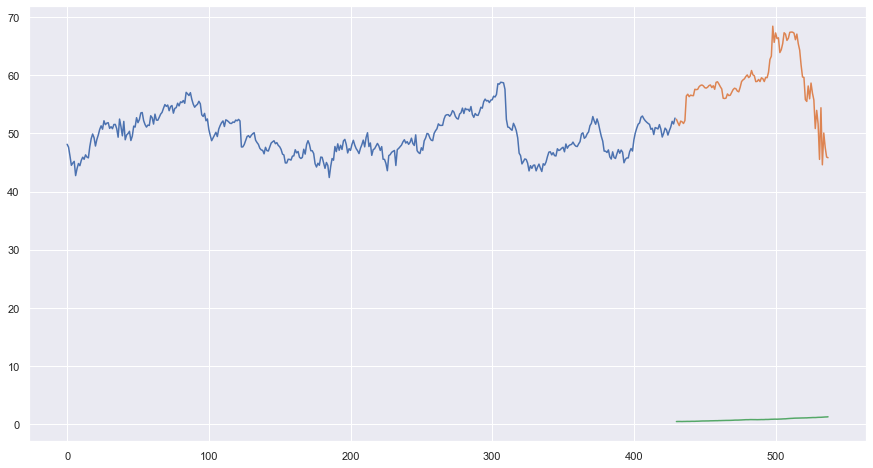

In [8]:
# copy predictions into valid data
valid['Predictions'] = 0
valid['Predictions'] = preds

# plot predict values
rcParams['figure.figsize'] = 15,8
plt.plot(train['close'])
plt.plot(valid[['close','Predictions']])

plt.savefig('.\\images\\Close_Stock_Price_Best_Model_Predict_Moving_Average_lv1.jpg')

The previous graph shows the correctness of the results previously supported by the metrics. In conclusion 'Moving Average' is not an appropriate predictive technique for this data set.

### 4.2 Linear Regression

In [9]:
# create empty dataset
new_data = pd.DataFrame(index=range(0, len(df_adj)), columns=['date', 'close'])

In [10]:
# copy values to new structure
for i in range(0, len(df_adj)):
    new_data['date'][i] = df_adj.date[i]
    new_data['close'][i] = df_adj.close[i]
    
new_data.head(5)

,date,close
0,2018-01-31,48.14
1,2018-02-01,47.65
2,2018-02-02,46.15
3,2018-02-05,44.52
4,2018-02-06,44.91


In [11]:
# create features
add_datepart(new_data, 'date')

# remove atribute 'Elapsed', axis=1 means colummn
new_data.drop('Elapsed', axis=1, inplace=True)

new_data.head(5)

,close,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,48.14,2018,1,5,31,2,31,True,False,False,False,False,False
1,47.65,2018,2,5,1,3,32,False,True,False,False,False,False
2,46.15,2018,2,5,2,4,33,False,False,False,False,False,False
3,44.52,2018,2,6,5,0,36,False,False,False,False,False,False
4,44.91,2018,2,6,6,1,37,False,False,False,False,False,False


In [12]:
# set train and valid rows len
train_rows = math.trunc(len(new_data) * train_size)
valid_rows = len(new_data) - train_rows

# splitting into train and validation
train = new_data[:train_rows]
valid = new_data[train_rows:]

# shapes of training set
print('\n Shape of trainning set:')
print(train.shape)

# shapes of validation set
print('\n Shape of validation set:')
print(valid.shape)


 Shape of trainning set:
(430, 13)

 Shape of validation set:
(108, 13)


In [13]:
# create train and valid dataset
x_train = train.drop('close', axis=1)
y_train = train['close']

x_valid = valid.drop('close', axis=1)
y_valid = valid['close']

# implement linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [14]:
# make predictions and find the rmse
preds = model.predict(x_valid)

In [15]:
# report performance
mse = mean_squared_error(y_valid, preds)
print('MSE: '+str(mse))

mae = mean_absolute_error(y_valid, preds)
print('MAE: '+str(mae))

rmse = math.sqrt(mean_squared_error(y_valid, preds))
print('RMSE: '+str(rmse))

mape = np.mean(np.abs(preds - y_valid)/np.abs(y_valid))
print('MAPE: '+str(mape))

MSE: 136.2286153198277
MAE: 10.751664974751812
RMSE: 11.671701474927625
MAPE: 0.17887929315262152


The MAPE indicator around 17.89% implies that the model accuracy give us a prediction close to 82.11% for the selected dataset. The RMSE 11.67% indicator provides us with a better metric, but far from satisfactory results.

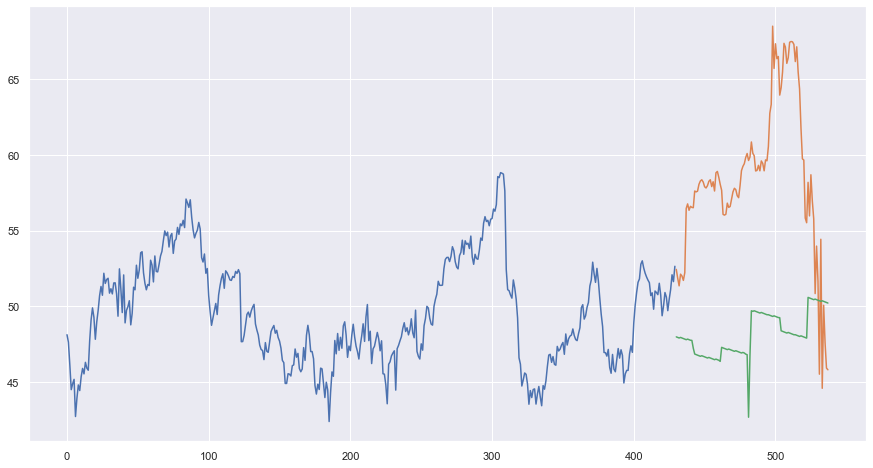

In [16]:
# add predictions to valid set
valid['Predictions'] = 0
valid['Predictions'] = preds

# add index value to train and valid set
valid.index = new_data[train_rows:].index
train.index = new_data[:train_rows].index

# plot
rcParams['figure.figsize'] = 15,8
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])

plt.savefig('.\\images\\Close_Stock_Price_Best_Model_Predict_Linear_Regression_lv1.jpg')

The previous graph shows the correctness of the results previously supported by the metrics. In conclusion 'Linear Regression' is not an appropriate predictive technique for this data set.

### 4.3 k-Nearest Neighbours

In [17]:
# create empty dataset
new_data = pd.DataFrame(index=range(0, len(df_adj)), columns=['date', 'close'])

# copy values to new structure
for i in range(0, len(df_adj)):
    new_data['date'][i] = df_adj.date[i]
    new_data['close'][i] = df_adj.close[i]

# create features
add_datepart(new_data, 'date')

# remove atribute 'Elapsed', axis=1 means colummn
new_data.drop('Elapsed', axis=1, inplace=True)

# set train and valid rows len
train_rows = math.trunc(len(new_data) * train_size)
valid_rows = len(new_data) - train_rows

# splitting into train and validation
train = new_data[:train_rows]
valid = new_data[train_rows:]

# shapes of training set
print('\n Shape of trainning set:')
print(train.shape)

# shapes of validation set
print('\n Shape of validation set:')
print(valid.shape)


 Shape of trainning set:
(430, 13)

 Shape of validation set:
(108, 13)


In [18]:
# create train and valid dataset
x_train = train.drop('close', axis=1)
y_train = train['close']

x_valid = valid.drop('close', axis=1)
y_valid = valid['close']

In [19]:
# scaling data
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)

x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

x_train.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.000000,0.078431,1.000000,0.50,0.079890,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.090909,0.078431,0.000000,0.75,0.082645,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.090909,0.078431,0.033333,1.00,0.085399,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.090909,0.098039,0.133333,0.00,0.093664,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.090909,0.098039,0.166667,0.25,0.096419,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
x_valid.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.818182,0.803922,0.500000,0.50,0.790634,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.818182,0.803922,0.533333,0.75,0.793388,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.818182,0.803922,0.566667,1.00,0.796143,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.818182,0.823529,0.666667,0.00,0.804408,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.818182,0.823529,0.700000,0.25,0.807163,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)
model

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [22]:
#fit the model and make predictions
model.fit(x_train, y_train)
preds = model.predict(x_valid)

In [23]:
# report performance
mse = mean_squared_error(y_valid, preds)
print('MSE: '+str(mse))

mae = mean_absolute_error(y_valid, preds)
print('MAE: '+str(mae))

rmse = math.sqrt(mean_squared_error(y_valid, preds))
print('RMSE: '+str(rmse))

mape = np.mean(np.abs(preds - y_valid)/np.abs(y_valid))
print('MAPE: '+str(mape))

MSE: 118.81462536865571
MAE: 10.23386316872428
RMSE: 10.90021217080914
MAPE: 0.1720715203626011


The MAPE indicator around 17.21% implies that the model accuracy give us a prediction close to 82.79% for the selected dataset. The RMSE 10.9% indicator provides us with a better metric, but far from satisfactory results

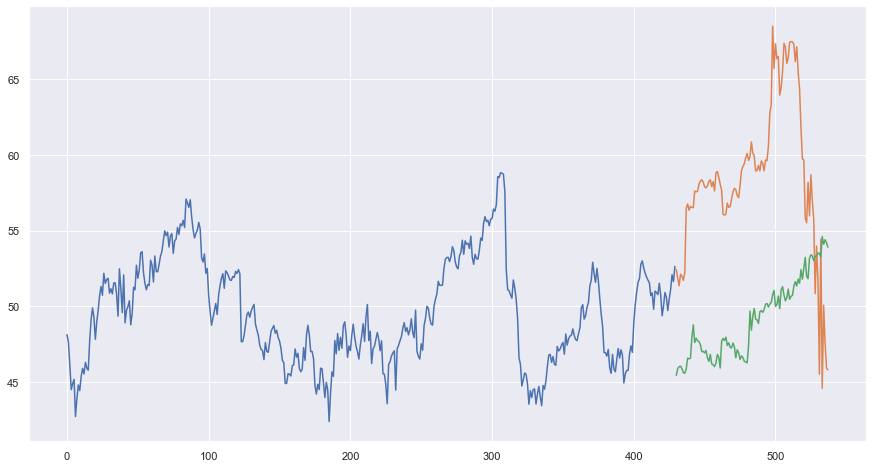

In [24]:
# copy pridictions to valid set
valid['Predictions'] = 0
valid['Predictions'] = preds

# plot
rcParams['figure.figsize'] = 15,8
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])

plt.savefig('.\\images\\Close_Stock_Price_Best_Model_Predict_LNN_lv1.jpg')

The previous graph shows the correctness of the results previously supported by the metrics. In conclusion 'k-Nearest Neighbours' is not an appropriate predictive technique for this data set.

### 4.4 Auto ARIMA

In [25]:
# create empty dataset
new_data = pd.DataFrame(index=range(0, len(df_adj)), columns=['date', 'close'])

# copy values to new structure
for i in range(0, len(df_adj)):
    new_data['date'][i] = df_adj.date[i]
    new_data['close'][i] = df_adj.close[i]

# set train and valid rows len
train_rows = math.trunc(len(new_data) * train_size)
valid_rows = len(new_data) - train_rows

# splitting into train and validation
train = new_data[:train_rows]
valid = new_data[train_rows:]

# shapes of training set
print('\n Shape of trainning set:')
print(train.shape)

# shapes of validation set
print('\n Shape of validation set:')
print(valid.shape)    


 Shape of trainning set:
(430, 2)

 Shape of validation set:
(108, 2)


In [26]:
# set sub dataset 
training = train['close']
validation = valid['close']

model = auto_arima(training, 
                   start_p=1, 
                   start_q=1,
                   max_p=3, 
                   max_q=3, 
                   m=12,
                   start_P=0, 
                   seasonal=True,
                   d=1, 
                   D=1, 
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True)
model.fit(training)

forecast = model.predict(n_periods=valid_rows)
forecast = pd.DataFrame(forecast, index = valid.index, columns=['Prediction'])

Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1199.105, BIC=1219.270, Time=1.464 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=1446.036, BIC=1454.103, Time=0.055 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=1331.534, BIC=1347.666, Time=0.639 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1197.338, BIC=1213.470, Time=0.992 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=False); AIC=1444.062, BIC=1448.095, Time=0.046 seconds
Fit ARIMA: (1, 1, 1)x(0, 1, 0, 12) (constant=True); AIC=1446.193, BIC=1462.325, Time=0.283 seconds
Fit ARIMA: (1, 1, 1)x(1, 1, 1, 12) (constant=True); AIC=1200.928, BIC=1225.127, Time=1.859 seconds
Near non-invertible roots for order (1, 1, 1)(1, 1, 1, 12); setting score to inf (at least one inverse r

In [27]:
# report performance
mse = mean_squared_error(valid['close'], forecast['Prediction'])
print('MSE: '+str(mse))

mae = mean_absolute_error(valid['close'], forecast['Prediction'])
print('MAE: '+str(mae))

rmse = math.sqrt(mean_squared_error(valid['close'], forecast['Prediction']))
print('RMSE: '+str(rmse))

mape = np.mean(np.abs(forecast['Prediction'] - valid['close'])/np.abs(valid['close']))
print('MAPE: '+str(mape))

MSE: 43.258533371215144
MAE: 5.598229809351311
RMSE: 6.577121967184062
MAPE: 0.09390110627978958


The MAPE indicator around 9.39% implies that the model accuracy give us a prediction close to 90.61% for the selected dataset. The RMSE 6.57% indicator provides us with a better metric, but far from satisfactory results

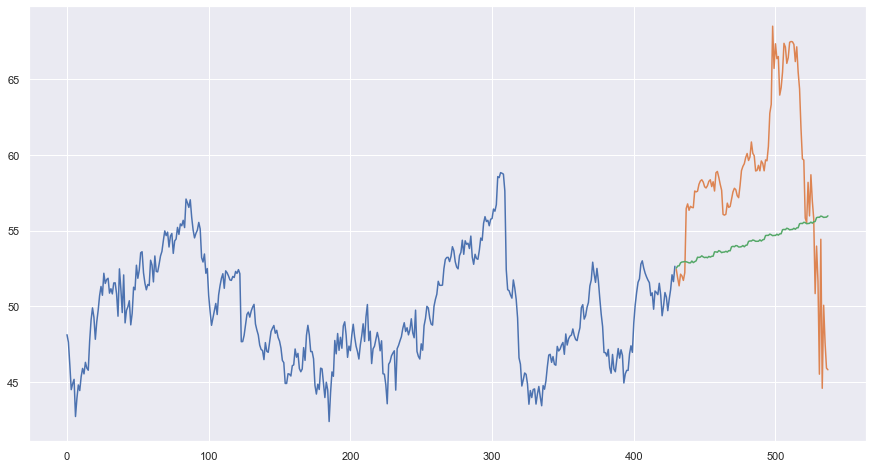

In [28]:
# plot
rcParams['figure.figsize'] = 15,8
plt.plot(train['close'])
plt.plot(valid['close'])

# plot
rcParams['figure.figsize'] = 15,8
plt.plot(forecast['Prediction'])

plt.savefig('.\\images\\Close_Stock_Price_Best_Model_Predict_Auto_Arima_lv1.jpg')

The previous graph shows the correctness of the results previously supported by the metrics. In conclusion 'Auto ARIMA' is not an appropriate predictive technique for this data set.

### 4.5 ARIMA    

In [29]:
# create empty dataset
new_data = pd.DataFrame(index=range(0, len(df_adj)), columns=['date', 'close'])

# copy values to new structure
for i in range(0, len(df_adj)):
    new_data['date'][i] = df_adj.date[i]
    new_data['close'][i] = df_adj.close[i]

# set train and valid rows len
train_rows = math.trunc(len(new_data) * train_size)
valid_rows = len(new_data) - train_rows

# splitting into train and validation
train = new_data[:train_rows]
valid = new_data[train_rows:]

# shapes of training set
print('\n Shape of trainning set:')
print(train.shape)

# shapes of validation set
print('\n Shape of validation set:')
print(valid.shape)    


 Shape of trainning set:
(430, 2)

 Shape of validation set:
(108, 2)


In [30]:
# set sub dataset 
training = train['close']
validation = valid['close']

model_autoARIMA = auto_arima(training, 
                             start_p=0, 
                             start_q=0,
                             test='adf',       # use adftest to find optimal 'd'
                             max_p=3, 
                             max_q=3,          # maximum p and q
                             m=1,              # frequency of series
                             d=None,           # let model determine 'd'
                             seasonal=False,   # No Seasonality
                             start_P=0, 
                             D=0, 
                             trace=True,
                             error_action='ignore',  
                             suppress_warnings=True, 
                             stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1179.449, BIC=1187.572, Time=0.078 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1177.440, BIC=1189.625, Time=0.067 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1177.649, BIC=1189.834, Time=0.069 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=1177.501, BIC=1181.562, Time=0.008 seconds
Fit ARIMA: (2, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1179.340, BIC=1195.586, Time=0.079 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1179.407, BIC=1195.653, Time=0.245 seconds
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1180.883, BIC=1201.190, Time=0.190 seconds
Total fit time: 0.759 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  430
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -585.720
Dat

So the Auto ARIMA model provided the value of p,d, and q as SARIMAX(1, 1, 0) respectively. Before moving forward, let’s review the residual plots from auto ARIMA.

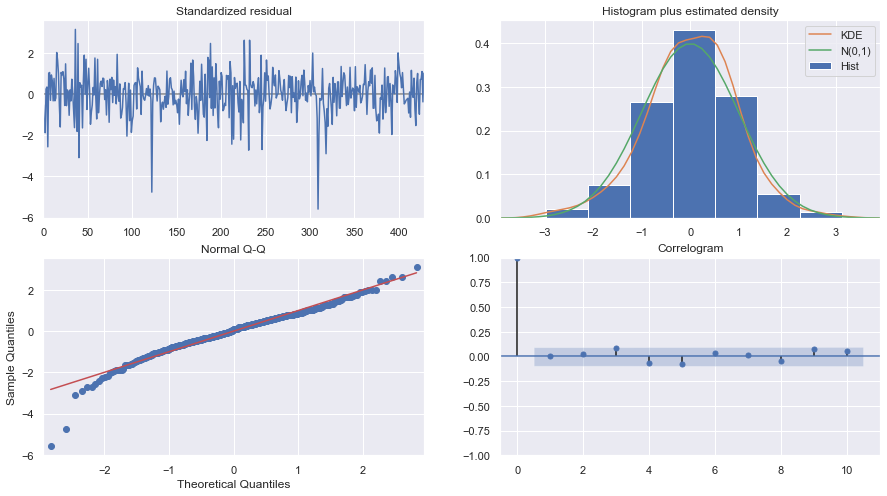

In [31]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))

plt.savefig('.\\images\\Close_Stock_Price_Best_Model_Predict_Arima_Auto_lv1.jpg')

So how to interpret the plot diagnostics?

- **Top left**: The residual errors seem to fluctuate around a mean of zero and and do not have a uniform variance.
- **Top Right**: The density plot suggest normal distribution with mean zero.
- **Bottom left**: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed. As can be easily seen on the left of the graph
- **Bottom Right**: The `Correlogram`, aka, `ACF` plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

Overall, it seems to be a good fit. Let’s start forecasting the stock prices. Next, create an ARIMA model with provided optimal parameters p, d and q.

#### Obtained by the algorithm

In [32]:
modelsegA = ARIMA(np.asarray(training), order=(1, 1, 0))  
fittedsegA = modelsegA.fit(disp=-1)  
print(fittedsegA.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  429
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -585.720
Method:                       css-mle   S.D. of innovations              0.948
Date:                Sat, 28 Mar 2020   AIC                           1177.440
Time:                        00:47:25   BIC                           1189.625
Sample:                             1   HQIC                          1182.252
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0104      0.042      0.249      0.803      -0.071       0.092
ar.L1.D.y     -0.0965      0.048     -2.007      0.045      -0.191      -0.002
                                    Roots           

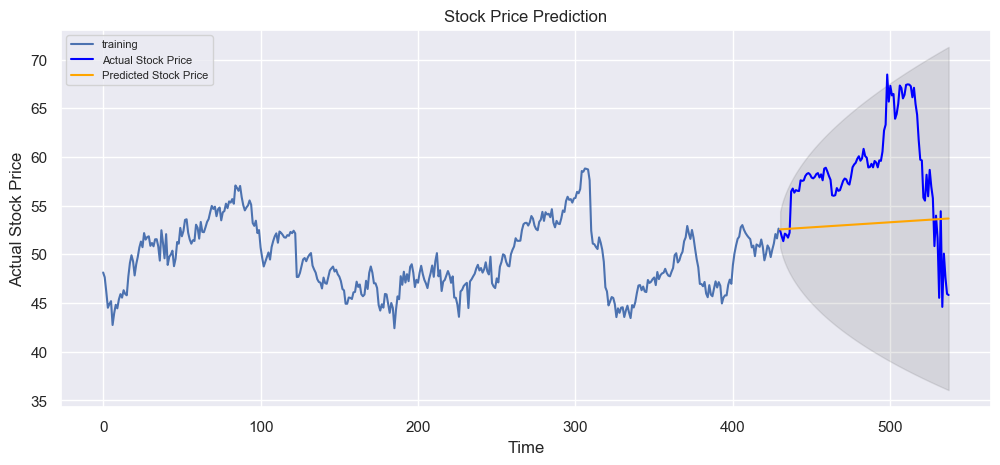

In [33]:
# Forecast
fcA, se, conf = fittedsegA.forecast(valid_rows, alpha=0.05)  # 95% confidence

fc_seriesA = pd.Series(fcA, index=validation.index)

lower_seriesA = pd.Series(conf[:, 0], index=validation.index)
upper_seriesA = pd.Series(conf[:, 1], index=validation.index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(training, label='training')
plt.plot(validation, color = 'blue', label='Actual Stock Price')
plt.plot(fc_seriesA, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_seriesA.index, lower_seriesA, upper_seriesA, color='k', alpha=.10)
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [34]:
# report performance
mse = mean_squared_error(validation, fcA)
print('MSE: '+str(mse))

mae = mean_absolute_error(validation, fcA)
print('MAE: '+str(mae))

rmse = math.sqrt(mean_squared_error(validation, fcA))
print('RMSE: '+str(rmse))

mape = np.mean(np.abs(fcA - validation)/np.abs(validation))
print('MAPE: '+str(mape))

MSE: 54.16473267511242
MAE: 6.334147227392571
RMSE: 7.359669331913794
MAPE: 0.10517845777382465


#### Suggested by the referred article [Here](https://towardsdatascience.com/stock-market-forecasting-using-time-series-c3d21f2dd37f)

In [35]:
modelsegB = ARIMA(np.asarray(training), order=(3, 1, 2))  
fittedsegB = modelsegB.fit(disp=-1)  
print(fittedsegB.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  429
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -580.437
Method:                       css-mle   S.D. of innovations              0.936
Date:                Sat, 28 Mar 2020   AIC                           1174.874
Time:                        00:47:32   BIC                           1203.304
Sample:                             1   HQIC                          1186.101
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0096      0.044      0.218      0.827      -0.077       0.096
ar.L1.D.y     -0.5148      0.227     -2.269      0.023      -0.959      -0.070
ar.L2.D.y     -0.7319      0.156     -4.705      0.0

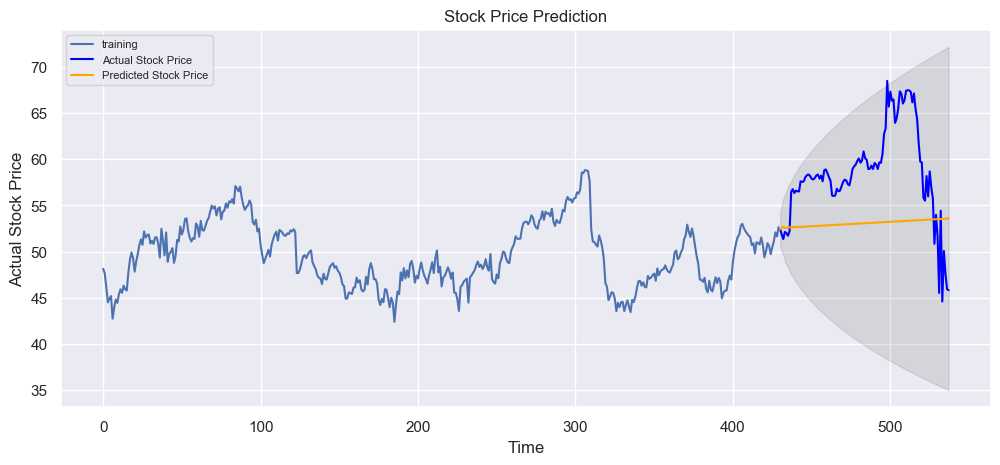

In [36]:
# Forecast
fcB, se, conf = fittedsegB.forecast(valid_rows, alpha=0.05)  # 95% confidence

fc_seriesB = pd.Series(fcB, index=validation.index)

lower_seriesB = pd.Series(conf[:, 0], index=validation.index)
upper_seriesB = pd.Series(conf[:, 1], index=validation.index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(training, label='training')
plt.plot(validation, color = 'blue', label='Actual Stock Price')
plt.plot(fc_seriesB, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_seriesB.index, lower_seriesB, upper_seriesB, color='k', alpha=.10)
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [37]:
# report performance
mse = mean_squared_error(validation, fcB)
print('MSE: '+str(mse))

mae = mean_absolute_error(validation, fcB)
print('MAE: '+str(mae))

rmse = math.sqrt(mean_squared_error(validation, fcB))
print('RMSE: '+str(rmse))

mape = np.mean(np.abs(fcB - validation)/np.abs(validation))
print('MAPE: '+str(mape))

MSE: 54.79508409506788
MAE: 6.373709358234663
RMSE: 7.402370167390163
MAPE: 0.10579907777872058


#### Suggested by Time Series Decomposition [Here](https://github.com/erojaso/Forecasting-Stock-Prices/blob/master/02_stock_price_forecast_time_series_decomposition.ipynb)

In [38]:
modelsegC = ARIMA(np.asarray(training), order=(3,1,3))  
fittedsegC = modelsegC.fit(disp=-1)  
print(fittedsegC.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  429
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -580.138
Method:                       css-mle   S.D. of innovations              0.935
Date:                Sat, 28 Mar 2020   AIC                           1176.276
Time:                        00:47:41   BIC                           1208.767
Sample:                             1   HQIC                          1189.107
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0100      0.043      0.232      0.816      -0.074       0.094
ar.L1.D.y     -0.0828        nan        nan        nan         nan         nan
ar.L2.D.y     -0.4545        nan        nan        n

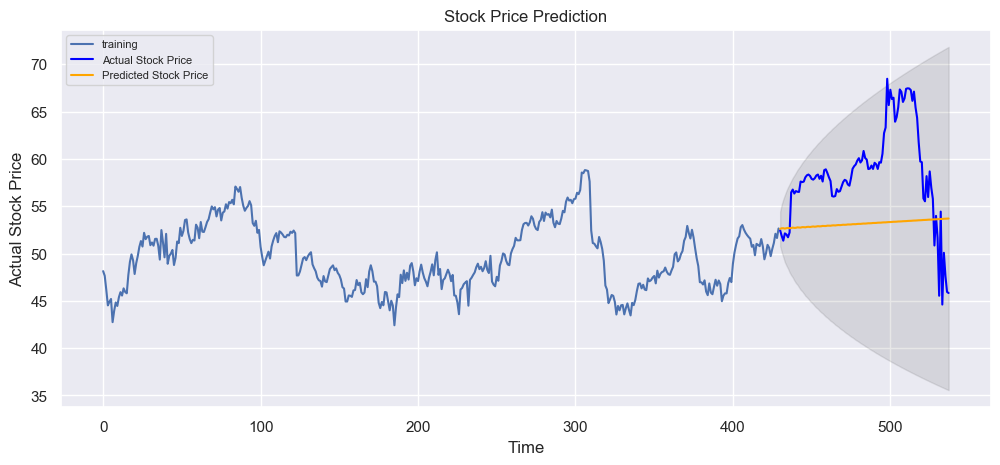

In [39]:
# Forecast
fcC, se, conf = fittedsegC.forecast(valid_rows, alpha=0.05)  # 95% confidence

fc_seriesC = pd.Series(fcC, index=validation.index)

lower_seriesC = pd.Series(conf[:, 0], index=validation.index)
upper_seriesC = pd.Series(conf[:, 1], index=validation.index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(training, label='training')
plt.plot(validation, color = 'blue', label='Actual Stock Price')
plt.plot(fc_seriesC, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_seriesC.index, lower_seriesC, upper_seriesC, color='k', alpha=.10)
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [40]:
# report performance
mse = mean_squared_error(validation, fcC)
print('MSE: '+str(mse))

mae = mean_absolute_error(validation, fcC)
print('MAE: '+str(mae))

rmse = math.sqrt(mean_squared_error(validation, fcC))
print('RMSE: '+str(rmse))

mape = np.mean(np.abs(fcC - validation)/np.abs(validation))
print('MAPE: '+str(mape))

MSE: 53.77278614083974
MAE: 6.306840314159156
RMSE: 7.332992986553291
MAPE: 0.10473208577809767


As seen in the indicators, none of the models did well. Looking at the individual metrics for each of the examples, these results are evident.

### 4.6 Prophet

In [41]:
# create empty dataset
new_data = pd.DataFrame(index=range(0, len(df_adj)), columns=['date', 'close'])

# copy values to new structure
for i in range(0, len(df_adj)):
    new_data['date'][i] = df_adj.date[i]
    new_data['close'][i] = df_adj.close[i]

# set train and valid rows len
train_rows = math.trunc(len(new_data) * train_size)
valid_rows = len(new_data) - train_rows

# preparing data
new_data.rename(columns={'close': 'y', 'date': 'ds'}, inplace=True)

# splitting into train and validation
train = new_data[:train_rows]
valid = new_data[train_rows:]

# shapes of training set
print('\n Shape of trainning set:')
print(train.shape)

# shapes of validation set
print('\n Shape of validation set:')
print(valid.shape)    


 Shape of trainning set:
(430, 2)

 Shape of validation set:
(108, 2)


In [44]:
# fit the model
model = Prophet(yearly_seasonality=True)
model.fit(train)

# predictions
close_prices = model.make_future_dataframe(periods=len(valid))
forecast = model.predict(close_prices)
forecast_valid = forecast['yhat'][train_rows:]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [45]:
# report performance
mse = mean_squared_error(valid['y'], forecast_valid)
print('MSE: '+str(mse))

mae = mean_absolute_error(valid['y'], forecast_valid)
print('MAE: '+str(mae))

rmse = math.sqrt(mean_squared_error(valid['y'], forecast_valid))
print('RMSE: '+str(rmse))

mape = np.mean(np.abs(forecast_valid - valid['y'])/np.abs(valid['y']))
print('MAPE: '+str(mape))

MSE: 42.50741612330407
MAE: 4.292827272643727
RMSE: 6.519771171084463
MAPE: 0.07776510621356614


The MAPE indicator around 7.78% implies that the model accuracy give us a prediction close to 92.22% for the selected dataset. The RMSE 6.52% indicator provides us with a better metric, but far from satisfactory results

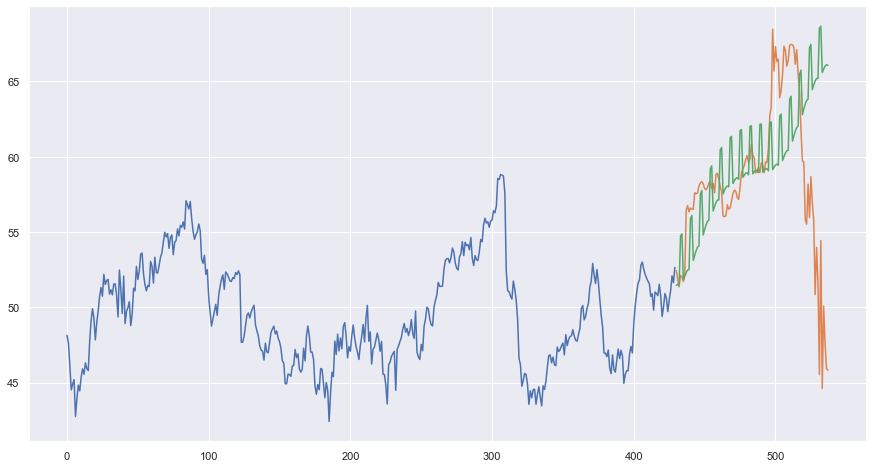

In [46]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = forecast_valid.values

rcParams['figure.figsize'] = 15,8
plt.plot(train['y'])
plt.plot(valid[['y', 'Predictions']])

plt.savefig('.\\images\\Close_Stock_Price_Best_Model_Predict_Prophet_lv1.jpg')

The previous graph shows the correctness of the results previously supported by the metrics. In conclusion 'Prophet' is not an appropriate predictive technique for this data set.

### 4.7 Long Short Term Memory (LSTM)

In [47]:
# create empty dataset
new_data = pd.DataFrame(index=range(0, len(df_adj)), columns=['date', 'close'])

# copy values to new structure
for i in range(0, len(df_adj)):
    new_data['date'][i] = df_adj.date[i]
    new_data['close'][i] = df_adj.close[i]
   
# setting index
new_data.index = new_data.date
new_data.drop('date', axis=1, inplace=True)   

# set train and valid rows len
train_rows = math.trunc(len(new_data) * train_size)
valid_rows = len(new_data) - train_rows

# splitting into train and validation
train = new_data[:train_rows]
valid = new_data[train_rows:]

# shapes of training set
print('\n Shape of trainning set:')
print(train.shape)

# shapes of validation set
print('\n Shape of validation set:')
print(valid.shape)


 Shape of trainning set:
(430, 1)

 Shape of validation set:
(108, 1)


In [48]:
#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(new_data)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [49]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

Epoch 1/1
 - 20s - loss: 0.0066


In [50]:
# predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1, 1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [51]:
# report performance
mse = mean_squared_error(valid, closing_price)
print('MSE: '+str(mse))

mae = mean_absolute_error(valid, closing_price)
print('MAE: '+str(mae))

rmse = math.sqrt(mean_squared_error(valid, closing_price))
print('RMSE: '+str(rmse))

mape = np.mean(np.abs(closing_price - valid)/np.abs(valid))
print('MAPE: '+str(mape))

MSE: 6.984520626490347
MAE: 2.1662805896335176
RMSE: 2.6428243654261907
MAPE: close    0.037012
dtype: float64


The MAPE indicator around 3.70% implies that the model accuracy give us a prediction close to 96.30% for the selected dataset. The RMSE 5.64% indicator provides us with a better metric, close to satisfactory results.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

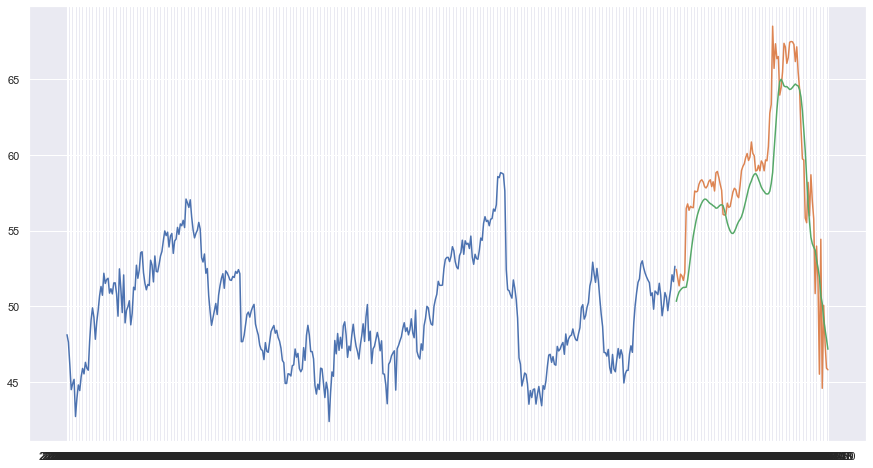

In [52]:
#for plotting
train = new_data[:train_rows]
valid = new_data[train_rows:]

valid['Predictions'] = closing_price

rcParams['figure.figsize'] = 15,8
plt.plot(train['close'])
plt.plot(valid[['close','Predictions']])

plt.savefig('.\\images\\Close_Stock_Price_Best_Model_Predict_LSTM_lv1.jpg')

The previous graph shows the correctness of the results previously supported by the metrics. In conclusion 'Long Short Term Memory (LSTM)' is an appropriate predictive technique for this data set.

### 4.8 LSTM Optimized [Source Here](https://towardsdatascience.com/forecasting-stock-prices-using-xgboost-a-detailed-walk-through-7817c1ff536a) - [Code](https://github.com/NGYB/Stocks/tree/master/StockPricePrediction)

In [53]:
#### Input params ##################
test_size = 0.2                # proportion of dataset to be used as test set
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set

N = 9                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features. 
                               # initial value before tuning

lstm_units=50                  # lstm param. initial value before tuning.
dropout_prob=1                 # lstm param. initial value before tuning.
optimizer='adam'               # lstm param. initial value before tuning.
epochs=1                       # lstm param. initial value before tuning.
batch_size=1                   # lstm param. initial value before tuning.

model_seed = 100

fontsize = 14
ticklabelsize = 14
####################################

# Set seeds to ensure same output results
seed(101)
tf.random.set_seed(model_seed) # set_random_seed(model_seed)

In [54]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [55]:
def get_x_y(data, N, offset):
    """
    Split data into x (features) and y (target)
    """
    x, y = [], []
    for i in range(offset, len(data)):
        x.append(data[i-N:i])
        y.append(data[i])
    x = np.array(x)
    y = np.array(y)
    
    return x, y

In [56]:
def get_x_scaled_y(data, N, offset):
    """
    Split data into x (features) and y (target)
    We scale x to have mean 0 and std dev 1, and return this.
    We do not scale y here.
    Inputs
        data     : pandas series to extract x and y
        N
        offset
    Outputs
        x_scaled : features used to predict y. Scaled such that each element has mean 0 and std dev 1
        y        : target values. Not scaled
        mu_list  : list of the means. Same length as x_scaled and y
        std_list : list of the std devs. Same length as x_scaled and y
    """
    x_scaled, y, mu_list, std_list = [], [], [], []
    for i in range(offset, len(data)):
        mu_list.append(np.mean(data[i-N:i]))
        std_list.append(np.std(data[i-N:i]))
        x_scaled.append((data[i-N:i]-mu_list[i-offset])/std_list[i-offset])
        y.append(data[i])
    x_scaled = np.array(x_scaled)
    y = np.array(y)
    
    return x_scaled, y, mu_list, std_list

In [57]:
def train_pred_eval_model(x_train_scaled, \
                          y_train_scaled, \
                          x_cv_scaled, \
                          y_cv, \
                          mu_cv_list, \
                          std_cv_list, \
                          lstm_units=50, \
                          dropout_prob=0.5, \
                          optimizer='adam', \
                          epochs=1, \
                          batch_size=1):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use LSTM here.
    Returns rmse, mape and predicted values
    Inputs
        x_train_scaled  : e.g. x_train_scaled.shape=(451, 9, 1). Here we are using the past 9 values to predict the next value
        y_train_scaled  : e.g. y_train_scaled.shape=(451, 1)
        x_cv_scaled     : use this to do predictions 
        y_cv            : actual value of the predictions
        mu_cv_list      : list of the means. Same length as x_scaled and y
        std_cv_list     : list of the std devs. Same length as x_scaled and y 
        lstm_units      : lstm param
        dropout_prob    : lstm param
        optimizer       : lstm param
        epochs          : lstm param
        batch_size      : lstm param
    Outputs
        rmse            : root mean square error
        mape            : mean absolute percentage error
        est             : predictions
    '''
    # Create the LSTM network
    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1],1)))
    model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
    model.add(Dense(1))

    # Compile and fit the LSTM network
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=0)
    
    # Do prediction
    est_scaled = model.predict(x_cv_scaled)
    est = (est_scaled * np.array(std_cv_list).reshape(-1,1)) + np.array(mu_cv_list).reshape(-1,1)
    
    # Calculate RMSE and MAPE
#     print("x_cv_scaled = " + str(x_cv_scaled))
#     print("est_scaled = " + str(est_scaled))
#     print("est = " + str(est))
    rmse = math.sqrt(mean_squared_error(y_cv, est))
    mape = get_mape(y_cv, est)
    
    return rmse, mape, est

#### 4.8.1 Feature Engineering

In [58]:
# create empty dataset
new_data = pd.DataFrame(index=range(0, len(df_adj)), columns=['date', 'close'])

# copy values to new structure
for i in range(0, len(df_adj)):
    new_data['date'][i] = df_adj.date[i]
    new_data['close'][i] = df_adj.close[i]

# create features
add_datepart(new_data, 'date', drop=False)

# remove atribute 'Elapsed', axis=1 means colummn
new_data.drop('Elapsed', axis=1, inplace=True)
    
# set train and valid rows len
train_rows = math.trunc(len(new_data) * train_size)
valid_rows = len(new_data) - train_rows

# splitting into train and validation
train = new_data[:train_rows]
valid = new_data[train_rows:]

# shapes of training set
print('\n Shape of trainning set:')
print(train.shape)

# shapes of validation set
print('\n Shape of validation set:')
print(valid.shape)    


 Shape of trainning set:
(430, 14)

 Shape of validation set:
(108, 14)


In [59]:
new_data.info()
print('\n')
new_data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 538 entries, 0 to 537
Data columns (total 14 columns):
date                538 non-null datetime64[ns]
close               538 non-null object
Year                538 non-null int64
Month               538 non-null int64
Week                538 non-null int64
Day                 538 non-null int64
Dayofweek           538 non-null int64
Dayofyear           538 non-null int64
Is_month_end        538 non-null bool
Is_month_start      538 non-null bool
Is_quarter_end      538 non-null bool
Is_quarter_start    538 non-null bool
Is_year_end         538 non-null bool
Is_year_start       538 non-null bool
dtypes: bool(6), datetime64[ns](1), int64(6), object(1)
memory usage: 36.9+ KB




,date,close,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,2018-01-31,48.14,2018,1,5,31,2,31,True,False,False,False,False,False
1,2018-02-01,47.65,2018,2,5,1,3,32,False,True,False,False,False,False
2,2018-02-02,46.15,2018,2,5,2,4,33,False,False,False,False,False,False
3,2018-02-05,44.52,2018,2,6,5,0,36,False,False,False,False,False,False
4,2018-02-06,44.91,2018,2,6,6,1,37,False,False,False,False,False,False


#### 4.8.2 Training, Validation, Test split

In [60]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(new_data))
num_test = int(test_size*len(new_data))
num_train = len(new_data) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = new_data[:num_train][['date', 'close']]
cv = new_data[num_train:num_train+num_cv][['date', 'close']]
train_cv = new_data[:num_train+num_cv][['date', 'close']]
test = new_data[num_train+num_cv:][['date', 'close']]

print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 324
num_cv = 107
num_test = 107
train.shape = (324, 2)
cv.shape = (107, 2)
train_cv.shape = (431, 2)
test.shape = (107, 2)


#### 4.8.3 Feature Scaling

In [61]:
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(np.array(train['close']).reshape(-1,1))
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))

# Split into x and y
x_train_scaled, y_train_scaled = get_x_y(train_scaled, N, N)
print("x_train_scaled.shape = " + str(x_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))

scaler.mean_ = [50.017469]
scaler.var_ = [12.160103]
x_train_scaled.shape = (315, 9, 1)
y_train_scaled.shape = (315, 1)


In [62]:
# Scale the cv dataset
# Split into x and y
x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(np.array(train_cv['close']).reshape(-1,1), N, num_train)
print("x_cv_scaled.shape = " + str(x_cv_scaled.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("len(mu_cv_list) = " + str(len(mu_cv_list)))
print("len(std_cv_list) = " + str(len(std_cv_list)))

x_cv_scaled.shape = (107, 9, 1)
y_cv.shape = (107, 1)
len(mu_cv_list) = 107
len(std_cv_list) = 107


In [63]:
# Here we scale the train_cv set, for the final model
scaler_final = StandardScaler()
train_cv_scaled_final = scaler_final.fit_transform(np.array(train_cv['close']).reshape(-1,1))
print("scaler_final.mean_ = " + str(scaler_final.mean_))
print("scaler_final.var_ = " + str(scaler_final.var_))

# # Scale the test dataset
x_test_scaled, y_test, mu_test_list, std_test_list = get_x_scaled_y(np.array(['close']).reshape(-1,1), N, num_train+num_cv)
print("x_test_scaled.shape = " + str(x_test_scaled.shape))
print("y_test.shape = " + str(y_test.shape))
print("len(mu_test_list) = " + str(len(mu_test_list)))
print("len(std_test_list) = " + str(len(std_test_list)))

scaler_final.mean_ = [49.611578]
scaler_final.var_ = [11.393789]
x_test_scaled.shape = (0,)
y_test.shape = (0,)
len(mu_test_list) = 0
len(std_test_list) = 0


#### 4.8.4 Create and fit the LSTM network

In [77]:
# Create the LSTM network
model = Sequential()
model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1],1)))
model.add(Dropout(dropout_prob))
model.add(LSTM(units=lstm_units))
model.add(Dropout(dropout_prob))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=optimizer)
model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=2)

Epoch 1/1
 - 23s - loss: 0.2988


In [78]:
# Print model summary
model.summary()

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_119 (LSTM)              (None, 59, 50)            10400     
_________________________________________________________________
dropout_117 (Dropout)        (None, 59, 50)            0         
_________________________________________________________________
lstm_120 (LSTM)              (None, 50)                20200     
_________________________________________________________________
dropout_118 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_60 (Dense)             (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


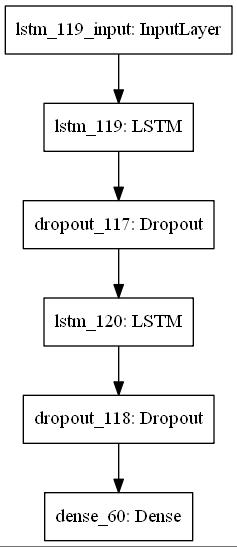

In [79]:
# Plot model and save to file
plot_model(model, to_file='.\\images\\Close_Stock_Price_LSTM_Opt_Model_lv1.jpg')

In [264]:
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [80]:
# Do prediction
est_scaled = model.predict(x_cv_scaled)
est = (est_scaled * np.array(std_cv_list).reshape(-1,1)) + np.array(mu_cv_list).reshape(-1,1)
print("est.shape = " + str(est.shape))

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, est))
print("RMSE = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_pct_bef_tuning = get_mape(y_cv, est)
print("MAPE = %0.3f%%" % mape_pct_bef_tuning)

est.shape = (107, 1)
RMSE = 1.671
MAPE = 2.732%


In [81]:
# report performance
mse = mean_squared_error(y_cv, est)
print('MSE: '+str(mse))

mae = mean_absolute_error(y_cv, est)
print('MAE: '+str(mae))

rmse = math.sqrt(mean_squared_error(y_cv, est))
print('RMSE: '+str(rmse))

mape = np.mean(np.abs(est - y_cv)/np.abs(y_cv))
print('MAPE: '+str(mape))

MSE: 2.7922204156472588
MAE: 1.321349441968441
RMSE: 1.6709938406969844
MAPE: 0.027315407011922477


The MAPE indicator around 2.73% implies that the model accuracy give us a prediction close to 97.27% for the selected dataset. The RMSE 1.67% indicator provides us with a better metric, close to satisfactory results.

Text(0, 0.5, 'USD')

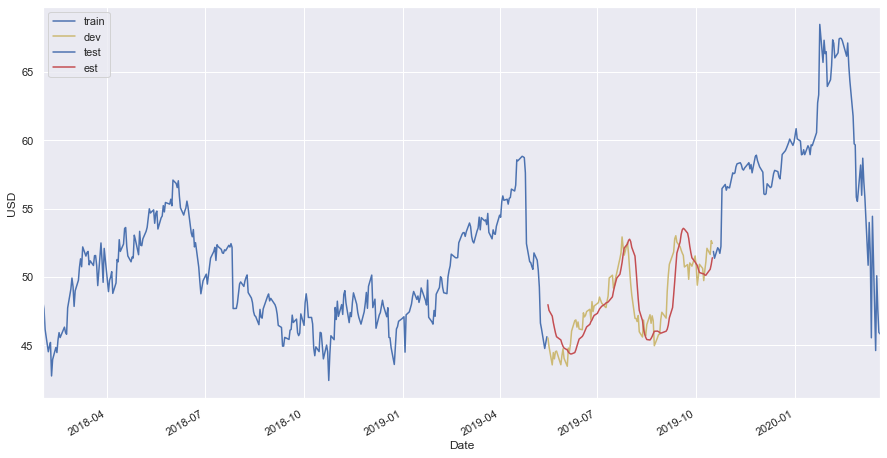

In [83]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 15, 8

est_df = pd.DataFrame({'est': est.reshape(-1), 
                       'y_cv': y_cv.reshape(-1),
                       'date': cv['date']})

ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='b-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'est'])
ax.set_xlabel("Date")
ax.set_ylabel("USD")

#### 4.8.4 Tuning N (no. of days to use as features)

In [84]:
param_label = 'N'
param_list = range(3, 60)

error_rate = {param_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
    
    # Split train into x and y
    x_train_scaled, y_train_scaled = get_x_y(train_scaled, param, param)

    # Split cv into x and y
    x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(np.array(train_cv['close']).reshape(-1,1), param, num_train)
    
    # Train, predict and eval model
    rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                          y_train_scaled, \
                                          x_cv_scaled, \
                                          y_cv, \
                                          mu_cv_list, \
                                          std_cv_list, \
                                          lstm_units=lstm_units, \
                                          dropout_prob=dropout_prob, \
                                          optimizer=optimizer, \
                                          epochs=epochs, \
                                          batch_size=batch_size)
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate


Minutes taken = 12.060065070788065


,N,rmse,mape_pct
0,3,1.091041,1.756546
1,4,1.174283,1.844474
2,5,1.218478,1.918122
3,6,1.312773,2.058108
4,7,1.362653,2.132004
5,8,1.331064,2.086066
6,9,1.474936,2.317675
7,10,1.387815,2.184539
8,11,1.404508,2.208189
9,12,1.337554,2.079776


Text(0, 0.5, 'RMSE/MAPE(%)')

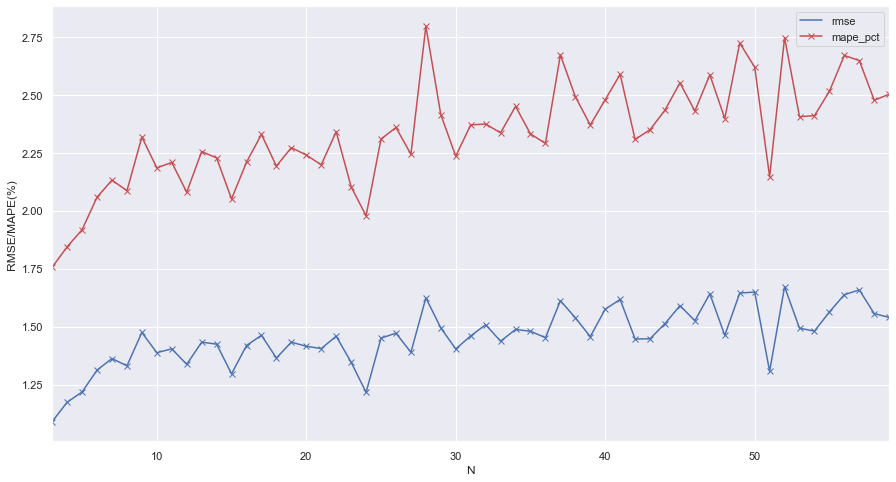

In [85]:
# Plot RMSE 
rcParams['figure.figsize'] = 15, 8

ax = error_rate.plot(x='N', y='rmse', style='bx-', grid=True)
ax = error_rate.plot(x='N', y='mape_pct', style='rx-', grid=True, ax=ax)
ax.set_xlabel("N")
ax.set_ylabel("RMSE/MAPE(%)")

In [86]:
# report performance
mse = mean_squared_error(y_cv, est)
print('MSE: '+str(mse))

mae = mean_absolute_error(y_cv, est)
print('MAE: '+str(mae))

rmse = math.sqrt(mean_squared_error(y_cv, est))
print('RMSE: '+str(rmse))

mape = np.mean(np.abs(est - y_cv)/np.abs(y_cv))
print('MAPE: '+str(mape))

# Get optimum value for param
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
N_opt = temp['N'].values[0]

MSE: 2.7922204156472588
MAE: 1.321349441968441
RMSE: 1.6709938406969844
MAPE: 0.027315407011922477


In [87]:
temp

,N,rmse,mape_pct
0,3,1.091041,1.756546


In [88]:
N_opt

3

In [89]:
param_list = [1, 10, 20, 30, 40, 50]

param2_label = 'batch_size'
param2_list = [8, 16, 32, 64, 128]

# Split train into x and y
x_train_scaled, y_train_scaled = get_x_y(train_scaled, N_opt, N_opt)

# Split cv into x and y
x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(np.array(train_cv['close']).reshape(-1,1), N_opt, num_train)

error_rate = {param_label: [], param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
    
    for param2 in tqdm_notebook(param2_list):
    
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                              y_train_scaled, \
                                              x_cv_scaled, \
                                              y_cv, \
                                              mu_cv_list, \
                                              std_cv_list, \
                                              lstm_units=lstm_units, \
                                              dropout_prob=dropout_prob, \
                                              optimizer=optimizer, \
                                              epochs=param, \
                                              batch_size=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate



Minutes taken = 3.4689619819323223


,N,batch_size,rmse,mape_pct
0,1,8,1.075135,1.729283
1,1,16,0.982700,1.594848
2,1,32,0.961265,1.563718
3,1,64,0.947173,1.542489
4,1,128,0.945485,1.539195
5,10,8,0.987025,1.602229
6,10,16,1.032183,1.669162
7,10,32,1.054585,1.701641
8,10,64,1.074911,1.731813
9,10,128,1.010654,1.635748


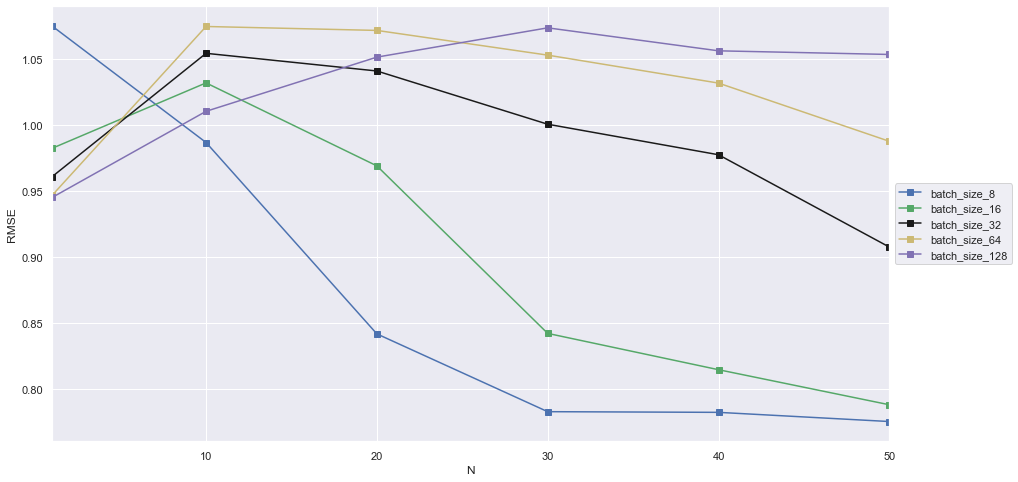

In [90]:
rcParams['figure.figsize'] = 15, 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure
# ax.set_xlim([10, 50])
# ax.set_ylim([0, 5])

In [91]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
epochs_opt = temp[param_label].values[0]
batch_size_opt = temp[param2_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(epochs_opt))
print("optimum " + param2_label + " = " + str(batch_size_opt))

min RMSE = 0.776
min MAPE = 1.322%
optimum N = 50
optimum batch_size = 8


#### 4.8.5 Tuning model - LSTM units and dropout prob

In [92]:
param_list = [10, 50, 64, 128]

param2_label = 'dropout_prob'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [], param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
    
    for param2 in tqdm_notebook(param2_list):
    
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                              y_train_scaled, \
                                              x_cv_scaled, \
                                              y_cv, \
                                              mu_cv_list, \
                                              std_cv_list, \
                                              lstm_units=param, \
                                              dropout_prob=param2, \
                                              optimizer=optimizer, \
                                              epochs=epochs_opt, \
                                              batch_size=batch_size_opt)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate



Minutes taken = 7.697764348983765


,N,dropout_prob,rmse,mape_pct
0,10,0.5,0.992904,1.614737
1,10,0.6,0.972660,1.583588
2,10,0.7,1.016924,1.646238
3,10,0.8,1.020601,1.651149
4,10,0.9,0.977189,1.586623
5,10,1.0,0.804699,1.355541
6,50,0.5,0.794407,1.339599
7,50,0.6,0.823441,1.374156
8,50,0.7,0.845548,1.405626
9,50,0.8,0.926901,1.516332


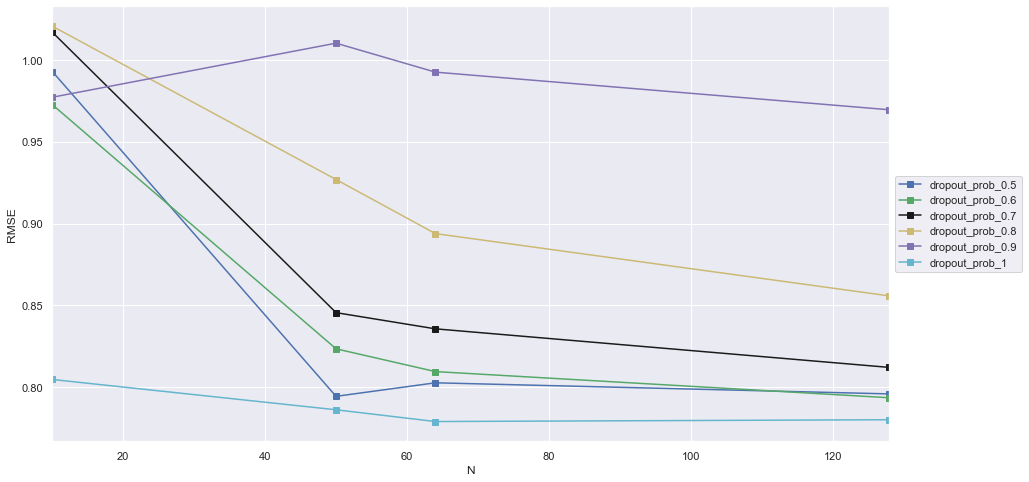

In [93]:
rcParams['figure.figsize'] = 15, 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [94]:
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
lstm_units_opt = temp[param_label].values[0]
dropout_prob_opt = temp[param2_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(lstm_units_opt))
print("optimum " + param2_label + " = " + str(dropout_prob_opt))

min RMSE = 0.779
min MAPE = 1.328%
optimum N = 64
optimum dropout_prob = 1.0


#### 4.8.5 Tuning model - optimizer

In [95]:
param_label = 'optimizer'
param_list = ['adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax', 'nadam']

error_rate = {param_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
   
    # Train, predict and eval model
    rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                          y_train_scaled, \
                                          x_cv_scaled, \
                                          y_cv, \
                                          mu_cv_list, \
                                          std_cv_list, \
                                          lstm_units=lstm_units_opt, \
                                          dropout_prob=dropout_prob_opt, \
                                          optimizer=param, \
                                          epochs=epochs_opt, \
                                          batch_size=batch_size_opt)
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate


Minutes taken = 2.4093664089838662


,optimizer,rmse,mape_pct
0,adam,0.777973,1.325605
1,sgd,1.000941,1.623097
2,rmsprop,0.776124,1.321946
3,adagrad,0.787643,1.338014
4,adadelta,0.768509,1.310062
5,adamax,0.778080,1.325055
6,nadam,0.777413,1.323303


Text(0, 0.5, 'RMSE/MAPE(%)')

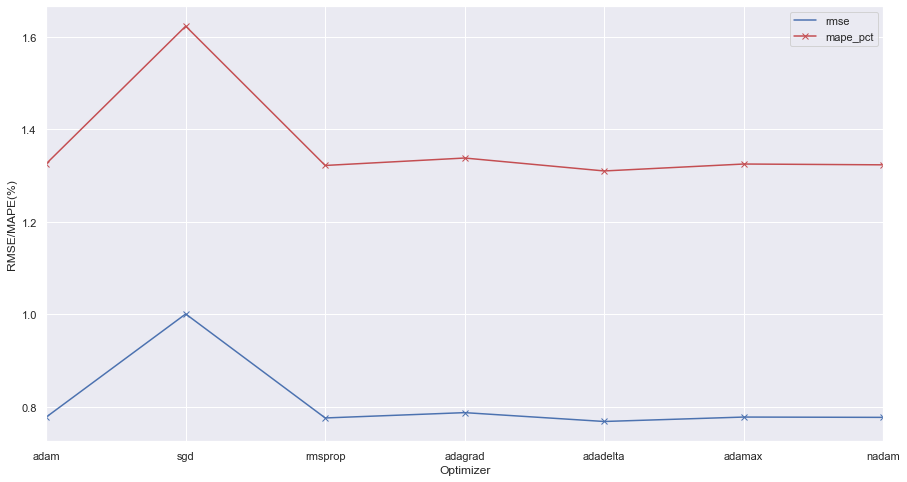

In [96]:
# Plot RMSE 
rcParams['figure.figsize'] = 15, 8

ax = error_rate.plot(x='optimizer', y='rmse', style='bx-', grid=True)
ax = error_rate.plot(x='optimizer', y='mape_pct', style='rx-', grid=True, ax=ax)
ax.set_xticklabels(param_list)
ax.set_xlabel("Optimizer")
ax.set_ylabel("RMSE/MAPE(%)")

In [97]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
optimizer_opt = temp[param_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(optimizer_opt))

min RMSE = 0.769
min MAPE = 1.310%
optimum optimizer = adadelta


In [98]:
d = {'param': ['N', 'lstm_units', 'dropout_prob', 'optimizer', 'epochs', 'batch_size', 'rmse', 'mape_pct'],
     'original': [N, lstm_units, dropout_prob, optimizer, epochs, batch_size, rmse_bef_tuning, mape_pct_bef_tuning],
     'after_tuning': [N_opt, lstm_units_opt, dropout_prob_opt, optimizer_opt, epochs_opt, batch_size_opt, error_rate['rmse'].min(), error_rate['mape_pct'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params

,param,original,after_tuning
0,N,9,3
1,lstm_units,50,64
2,dropout_prob,1,1
3,optimizer,adam,adadelta
4,epochs,1,50
5,batch_size,1,8
6,rmse,1.67099,0.768509
7,mape_pct,2.73154,1.31006


#### 4.8.6 Applying the Model

In [99]:
# Split train_cv into x and y
x_train_cv_scaled, y_train_cv_scaled = get_x_y(train_cv_scaled_final, N_opt, N_opt)

# Split test into x and y
x_test_scaled, y_test, mu_test_list, std_test_list = get_x_scaled_y(np.array(new_data['close']).reshape(-1,1), N_opt, num_train+num_cv)

# Train, predict and eval model
rmse, mape, est = train_pred_eval_model(x_train_cv_scaled, \
                                        y_train_cv_scaled, \
                                        x_test_scaled, \
                                        y_test, \
                                        mu_test_list, \
                                        std_test_list, \
                                        lstm_units=lstm_units_opt, \
                                        dropout_prob=dropout_prob_opt, \
                                        optimizer=optimizer_opt, \
                                        epochs=epochs_opt, \
                                        batch_size=batch_size_opt)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

RMSE on test set = 1.877
MAPE on test set = 1.962%


The MAPE indicator around 1.88% implies that the model accuracy give us a prediction close to 98.12% for the selected dataset. The RMSE 1.87% indicator provides us with a excelent metric and a satisfactory results.

Text(0, 0.5, 'USD')

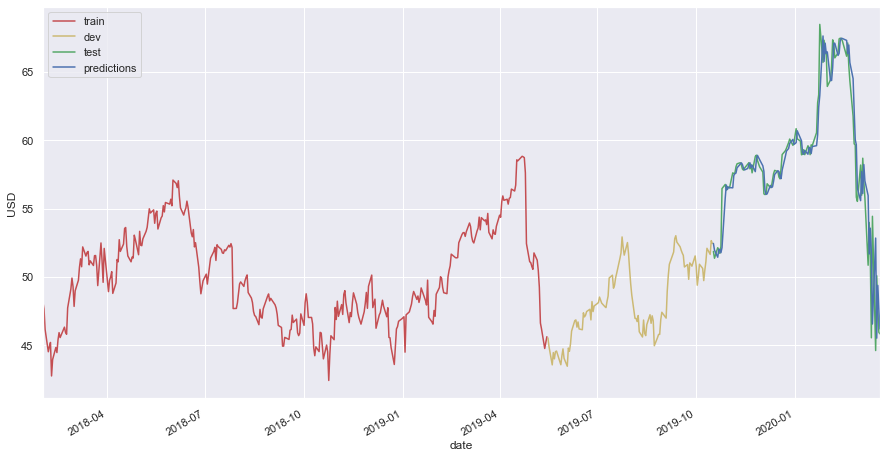

In [100]:
rcParams['figure.figsize'] = 15, 8

est_df = pd.DataFrame({'est': est.reshape(-1), 
                       'date': new_data[num_train+num_cv:]['date']})

ax = train.plot(x='date', y='close', style='r-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='b-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Test Dataset Overlapping')

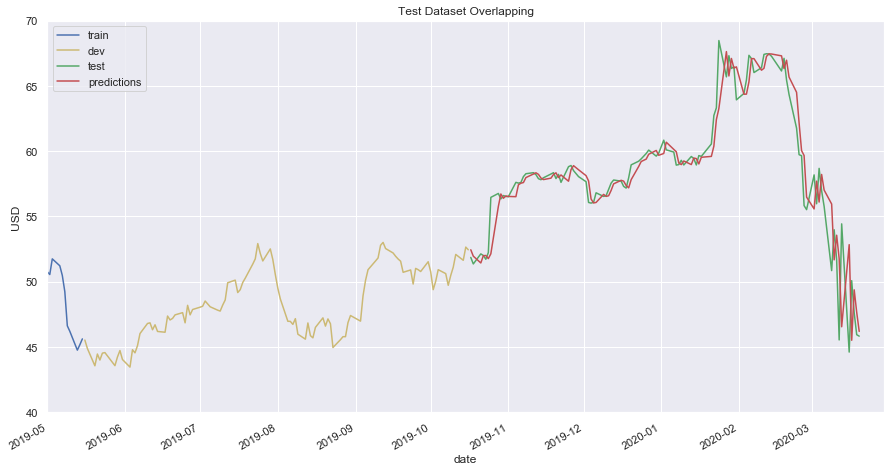

In [101]:
# set start and end date range
start_date = dt.datetime(2019, 5, 1)
end_date = dt.datetime(2020, 3, 30)

rcParams['figure.figsize'] = 15, 8 # width 10, height 8
ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([start_date, end_date])
ax.set_ylim([40, 70])
ax.set_title("Test Dataset Overlapping")

(40, 70)

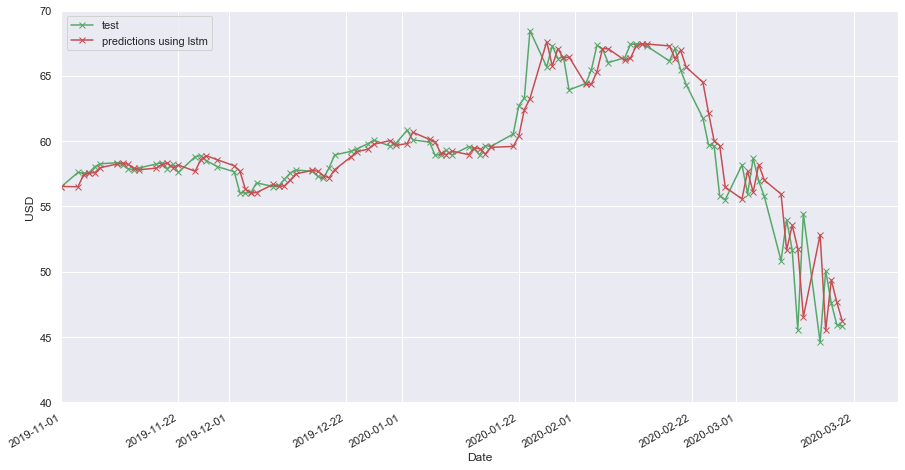

In [102]:
# set start and end date range
start_date = dt.datetime(2019, 11, 1)
end_date = dt.datetime(2020, 3, 30)

rcParams['figure.figsize'] = 15, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='close', style='gx-', grid=True)
ax = est_df.plot(x='date', y='est', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using lstm'], loc='upper left')
ax.set_xlabel("Date")
ax.set_ylabel("USD")
ax.set_xlim([start_date, end_date])
ax.set_ylim([40, 70])

In [103]:
# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

RMSE on test set = 1.877
MAPE on test set = 1.962%


The MAPE indicator around 1.88% implies that the model accuracy give us a prediction close to 98.12% for the selected dataset. The RMSE 1.87% indicator provides us with a best metric for satisfactory results.